In [63]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [64]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [65]:
len(words)

32033

In [66]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [67]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [68]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [69]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [70]:
C = torch.randn((27, 2))

In [71]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [72]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [73]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [74]:
h

tensor([[-1.0000, -0.9837, -0.9880,  ..., -0.9982, -1.0000,  0.9715],
        [-0.9928, -0.9608, -0.9998,  ..., -0.9988, -0.9997, -0.9953],
        [ 0.9747, -0.4940, -0.9997,  ..., -0.9997, -0.5004, -0.9977],
        ...,
        [-0.9910,  0.9731, -0.3904,  ..., -0.9768, -0.0070,  0.9508],
        [-0.9580,  0.4895, -0.6653,  ..., -0.9994, -0.8748,  0.6256],
        [-0.9963,  0.9906, -0.9637,  ..., -0.9954, -0.9695, -0.6254]])

In [75]:
h.shape

torch.Size([228146, 100])

In [76]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [77]:
logits = h @ W2 + b2

In [78]:
logits.shape

torch.Size([228146, 27])

In [79]:
counts = logits.exp()

In [80]:
prob = counts / counts.sum(1, keepdims=True)

In [81]:
prob.shape

torch.Size([228146, 27])

In [82]:
Y.shape

torch.Size([228146])

In [83]:
loss = -prob[torch.arange(32), Y[:32]].log().mean()
loss

tensor(16.9556)

In [84]:
# ------------ now made respectable :) ---------------

In [85]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [86]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [87]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [88]:
for p in parameters:
  p.requires_grad = True

In [89]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [90]:
lri = []
lossi = []
stepi = []

In [102]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (64,))
  
  # forward pass
  emb = C[Xtr[ix]] # (64, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (64, 200)
  logits = h @ W2 + b2 # (64, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

In [92]:
print(loss.item())

2.106840133666992


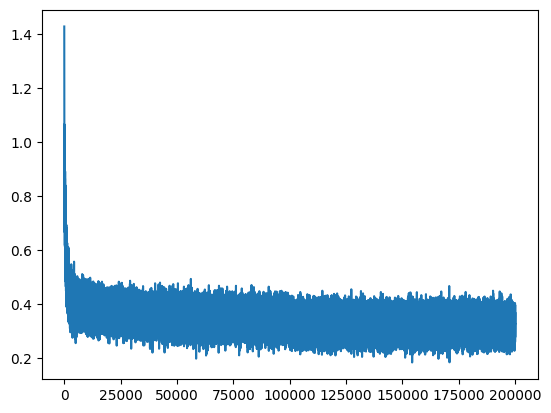

In [93]:
plt.plot(stepi, lossi)

In [94]:
C.shape

torch.Size([27, 10])

In [95]:
emb.shape

torch.Size([64, 3, 10])

In [96]:
emb = C[Xtr] # (Xtr.shape[0], 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (64, 100)
logits = h @ W2 + b2 # (64, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1181, grad_fn=<NllLossBackward0>)

In [97]:
emb = C[Xdev] # (64, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (64, 100)
logits = h @ W2 + b2 # (64, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1556, grad_fn=<NllLossBackward0>)

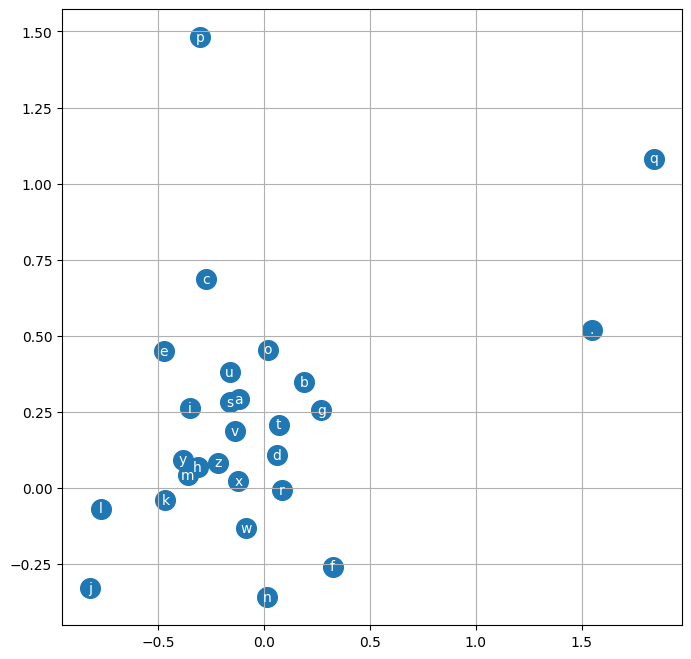

In [98]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [99]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [100]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [101]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
kayah.
see.
mel.
ryla.
rethan.
endraeg.
adelyn.
elin.
shi.
jen.
edelieananar.
katelmanter.
noshubrighhiriel.
kindreelynn.
novaley.
brence.
ryyah.
faeha.
kaysh.


In [ ]:
The best result of loss that I can get from tuning the hyperparameters is 2.1181 for training set and 2.1556 for validation set. 
n_embed = 64
n_hidden = 200